In [1]:
import torch
from torch.autograd import Function
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np



# Load and preprocess an image
def load_image(image_path):
    img = Image.open(image_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ])
    img_tensor = preprocess(img)
    img_tensor = img_tensor.unsqueeze(0)
    return img_tensor

# Function to perform Grad-CAM
class GradCam:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

        # Register a hook to capture gradients during backward pass
        self.hook = self.register_hooks()

    def register_hooks(self):
        def hook_fn(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        target_layer = self.model._modules.get(self.target_layer)
        hook = target_layer.register_forward_hook(hook_fn)
        return hook

    def remove_hooks(self):
        self.hook.remove()

    def forward(self, x):
        return self.model(x)

    def backward(self, output):
        self.model.zero_grad()
        output.backward()

    def generate_heatmap(self, input_tensor, class_idx):
        self.model.zero_grad()

        # Perform forward and backward pass
        output = self.forward(input_tensor)
        target = output[0][class_idx]
        self.backward(target)

        # Calculate the importance weights (gradients)
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)

        # Get the activations from the target layer
        target_layer_output = self.hook.output[0]

        # Weighted sum of activations to get the Grad-CAM heatmap
        grad_cam = torch.sum(weights * target_layer_output, dim=1, keepdim=True)
        grad_cam = F.relu(grad_cam)

        # Resize the heatmap to match the input image size
        grad_cam = F.interpolate(grad_cam, size=(input_tensor.shape[2], input_tensor.shape[3]), mode='bilinear', align_corners=False)

    



In [2]:
import torch.nn as nn
import torchvision

In [11]:
vgg = torchvision.models.vgg19(pretrained=True)

# disect the network to access its last convolutional layer
vgg.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [6]:
class Resi(nn.Module):
    def __init__(self):
        super(Resi, self).__init__()
        
        # get the pretrained VGG19 network
        self.vgg = torchvision.models.vgg19(pretrained=True)
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.vgg.features[:36]
        
        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        # get the classifier of the vgg19
        self.classifier = self.vgg.classifier
        
        
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.max_pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

In [32]:
# Load a pre-trained ResNet model
model = Resi()
model.eval()

# get the image from the dataloader
img = load_image("C:/Users/Prinzessin/projects/decentnet/datasceyence/examples/example_data/eye/AMD/A0001.jpg")

# get the most likely prediction of the model
pred = model(img) # .argmax(dim=1)

pred.argmax(dim=1)

tensor([117])

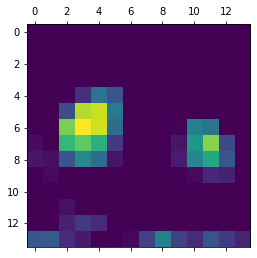

In [31]:
# get the gradient of the output with respect to the parameters of the model
#pred[:, 386].backward()
pred[:, 386].backward()
#  
# pull the gradients out of the model
gradients = model.get_activations_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = model.get_activations(img).detach()

# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]
    
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())